In [99]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from astropy.time import Time
from astropy import units as u
from astropy.constants import R_earth

In [100]:
# Orbital elements
GM = 398600.4405 *(u.km)**3/(u.s)**(2)   # Gravitational constant * Earth's Mass
R = R_earth.to(u.km)                     # Earth's Ratio
ec = 0.16561                             # Eccentricity
a = 1.30262 * R                          # Semi-major axis
w = (15*u.deg).to(u.rad)                 # Argument of periapsis

# Time of periapsis passage
tp = Time('2025-03-31 00:00:00', format='iso', scale='utc')
# Selected time for computing r(t) and phi(t)
t = Time('2025-04-01 00:00:00', format='iso', scale='utc')

In [101]:
# Newton-Raphson method to solve Kepler's equation
tol = 1e-10  # Tolerance
max = 1000   # Maximum number of iterations
def Kepler(ec, l, tol, max):
  E = l # Initial guess for eccentric anomaly
  for i in range(max):
    f_E = E - ec * np.sin(E) - l  # Function of the equation
    df_E = 1 - ec * np.cos(E)     # Derivative of the function
    E_new = E - f_E/df_E          # New guess for eccentric anomaly
    if abs(E_new - E) < tol:      # Check for convergence
      return E_new
    E = E_new
  raise ValueError(f"Newton-Raphson method did not converge after {max} iterations.")

In [86]:
# Compute the position (r and phi)
def position(t):
  delta_t = (t - tp).to(u.s)                           # Time since periapsis passage
  l = (np.sqrt(GM / a**3)*delta_t).value               # Mean anomaly
  E = Kepler(ec, l, tol, max)                          # Eccentric anomaly
  f = 2*np.arctan(np.sqrt((1+ec)/(1-ec))*np.tan(E/2))  # True anomaly
  r = (a*(1-ec**2)/(1+ec*np.cos(f))).to(u.km)
  phi = (w + f*u.rad).to(u.deg)
  return r, phi

r, phi = position(t)
print(f"r(t):", '\n', f'{r:.10f}', '\n')
print(f"phi(t):", '\n', f'{phi:.10f}')

r(t): 
 9658.4091505084 km 

phi(t): 
 185.5967106064 deg


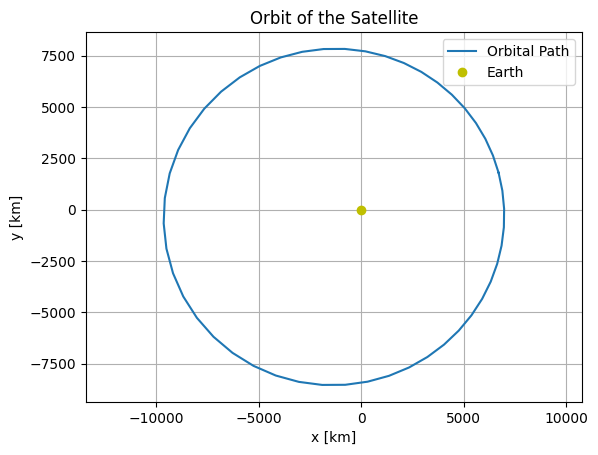

In [102]:
# Graph of the orbit in one period
def orbit():
  N = 500
  f_vals = np.linspace(0, 2 * np.pi)          # Generate values of true anomaly from 0 to 2π
  r_vals = a*(1-ec**2)/(1+ec*np.cos(f_vals))  # Compute r(f) for each value
  phi_vals = f_vals + w.value                 # Compute phi(f) for each value
  # Compute (x, y) in orbital plane:
  x = r_vals * np.cos(phi_vals)
  y = r_vals * np.sin(phi_vals)
  # Plot:
  plt.figure()
  plt.title("Orbit of the Satellite")
  plt.plot(x, y, label='Orbital Path')
  plt.plot(0, 0, 'yo', label='Earth')  # Earth at focus
  plt.xlabel('x [km]')
  plt.ylabel('y [km]')
  plt.axis('equal')
  plt.legend()
  plt.grid(True)
  plt.show()

orbit()

In [110]:
# Calculation of the time in which the satellite reaches the position r0
def date(r0):
  # Valid range of r
  r_min = (a*(1-ec))
  r_max = (a*(1+ec))
  if not (r_min <= r0 <= r_max):
    raise ValueError(f"r0 = {r0:.3f} is outside the orbital range ({r_min:.3f} to {r_max:.3f})")
  # Cheking for real values
  cos_f = ((a*(1-ec**2)/r0)-1)/ec
  if cos_f > 1:
    raise ValueError("No real solution for f, invalid r0.")
  # Calculation of the time:
  f = np.arccos(cos_f) # First time
  E = 2*np.arctan(np.sqrt((1-ec)/(1+ec))*np.tan(f/2))
  if E < 0:
    E += 2*np.pi
  l = E.value - ec*np.sin(E.value)
  t0 = (np.sqrt((a**3)/GM)*l)
  return t0 + tp

r0 = 1.5*R
t0 = date(r0)
print(f"Date in which the satellite reaches the position r0 =", r0, f':', '\n', t0)

Date in which the satellite reaches the position r0 = 9567.150000000001 km : 
 2025-03-31 00:53:09.855
